## 1. Projekat iz predmeta Mašinsko učenje

Klasifikacija po karakteristikama zemlje

Marija Cvetković 1940

Luka Kocić 2022

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv("input.csv")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 17 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   Soil_ID                            1000000 non-null  int64  
 1   Location_Latitude                  1000000 non-null  float64
 2   Location_Longitude                 1000000 non-null  float64
 3   Depth_cm                           1000000 non-null  float64
 4   Texture                            1000000 non-null  object 
 5   pH                                 1000000 non-null  float64
 6   Organic_Matter_%                   1000000 non-null  float64
 7   Moisture_Content_%                 1000000 non-null  float64
 8   Bulk_Density_g/cm³                 1000000 non-null  float64
 9   Nitrogen_N_ppm                     1000000 non-null  float64
 10  Phosphorus_P_ppm                   1000000 non-null  float64
 11  Potassium_K_ppm          

In [8]:
df.describe()

,Soil_ID,Location_Latitude,Location_Longitude,Depth_cm,pH,Organic_Matter_%,Moisture_Content_%,Bulk_Density_g/cm³,Nitrogen_N_ppm,Phosphorus_P_ppm,Potassium_K_ppm,Cation_Exchange_Capacity_meq/100g,Electrical_Conductivity_dS/m,Porosity_%,Water_Holding_Capacity_%
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,0.060208,-0.187684,17.503013,6.499917,5.500164,19.994861,1.199857,102.580566,30.006634,249.875195,25.010037,2.550400,37.501472,40.007685
std,288675.278932,51.946403,103.865450,7.218743,1.443158,2.597949,8.664421,0.230871,56.307008,11.545974,86.561417,8.655487,1.414580,7.214270,11.543025
min,1.000000,-89.999907,-179.999864,5.000025,4.000002,1.000005,5.000010,0.800001,5.000091,10.000015,100.000731,10.000014,0.100002,25.000007,20.000019
25%,250000.750000,-44.938762,-90.001356,11.251265,5.250710,3.249001,12.486926,1.000106,53.783290,20.005635,174.915582,17.507778,1.325367,31.253352,30.020650
50%,500000.500000,0.100075,-0.376740,17.510242,6.497696,5.505274,19.994249,1.199780,102.658544,30.007883,249.891170,25.017909,2.551018,37.490635,40.026669
75%,750000.250000,45.017411,89.726932,23.753234,7.751155,7.746259,27.511794,1.399679,151.361938,40.006229,324.752201,32.502019,3.776592,43.749108,49.984317
max,1000000.000000,89.999697,179.999778,29.999947,8.999986,9.999999,34.999977,1.599999,199.999944,49.999991,399.999812,39.999965,4.999999,49.999993,59.999935


In [9]:
df['Texture'].value_counts()

Texture
sandy     333463
loamy     333363
clayey    333174
Name: count, dtype: int64

Čišćenje podataka (data cleaning)

In [10]:
df.isnull().sum()

Soil_ID                              0
Location_Latitude                    0
Location_Longitude                   0
Depth_cm                             0
Texture                              0
pH                                   0
Organic_Matter_%                     0
Moisture_Content_%                   0
Bulk_Density_g/cm³                   0
Nitrogen_N_ppm                       0
Phosphorus_P_ppm                     0
Potassium_K_ppm                      0
Cation_Exchange_Capacity_meq/100g    0
Electrical_Conductivity_dS/m         0
Soil_Color                           0
Porosity_%                           0
Water_Holding_Capacity_%             0
dtype: int64

In [11]:
df.duplicated().any()

False

In [12]:
df = df.drop_duplicates()

Outlieri:
1.Vizuelizacija


Box plot nad svim numerickim podacima

In [13]:
number_columns= df.select_dtypes(include='number').drop(columns=['Soil_ID'])

<Axes: >

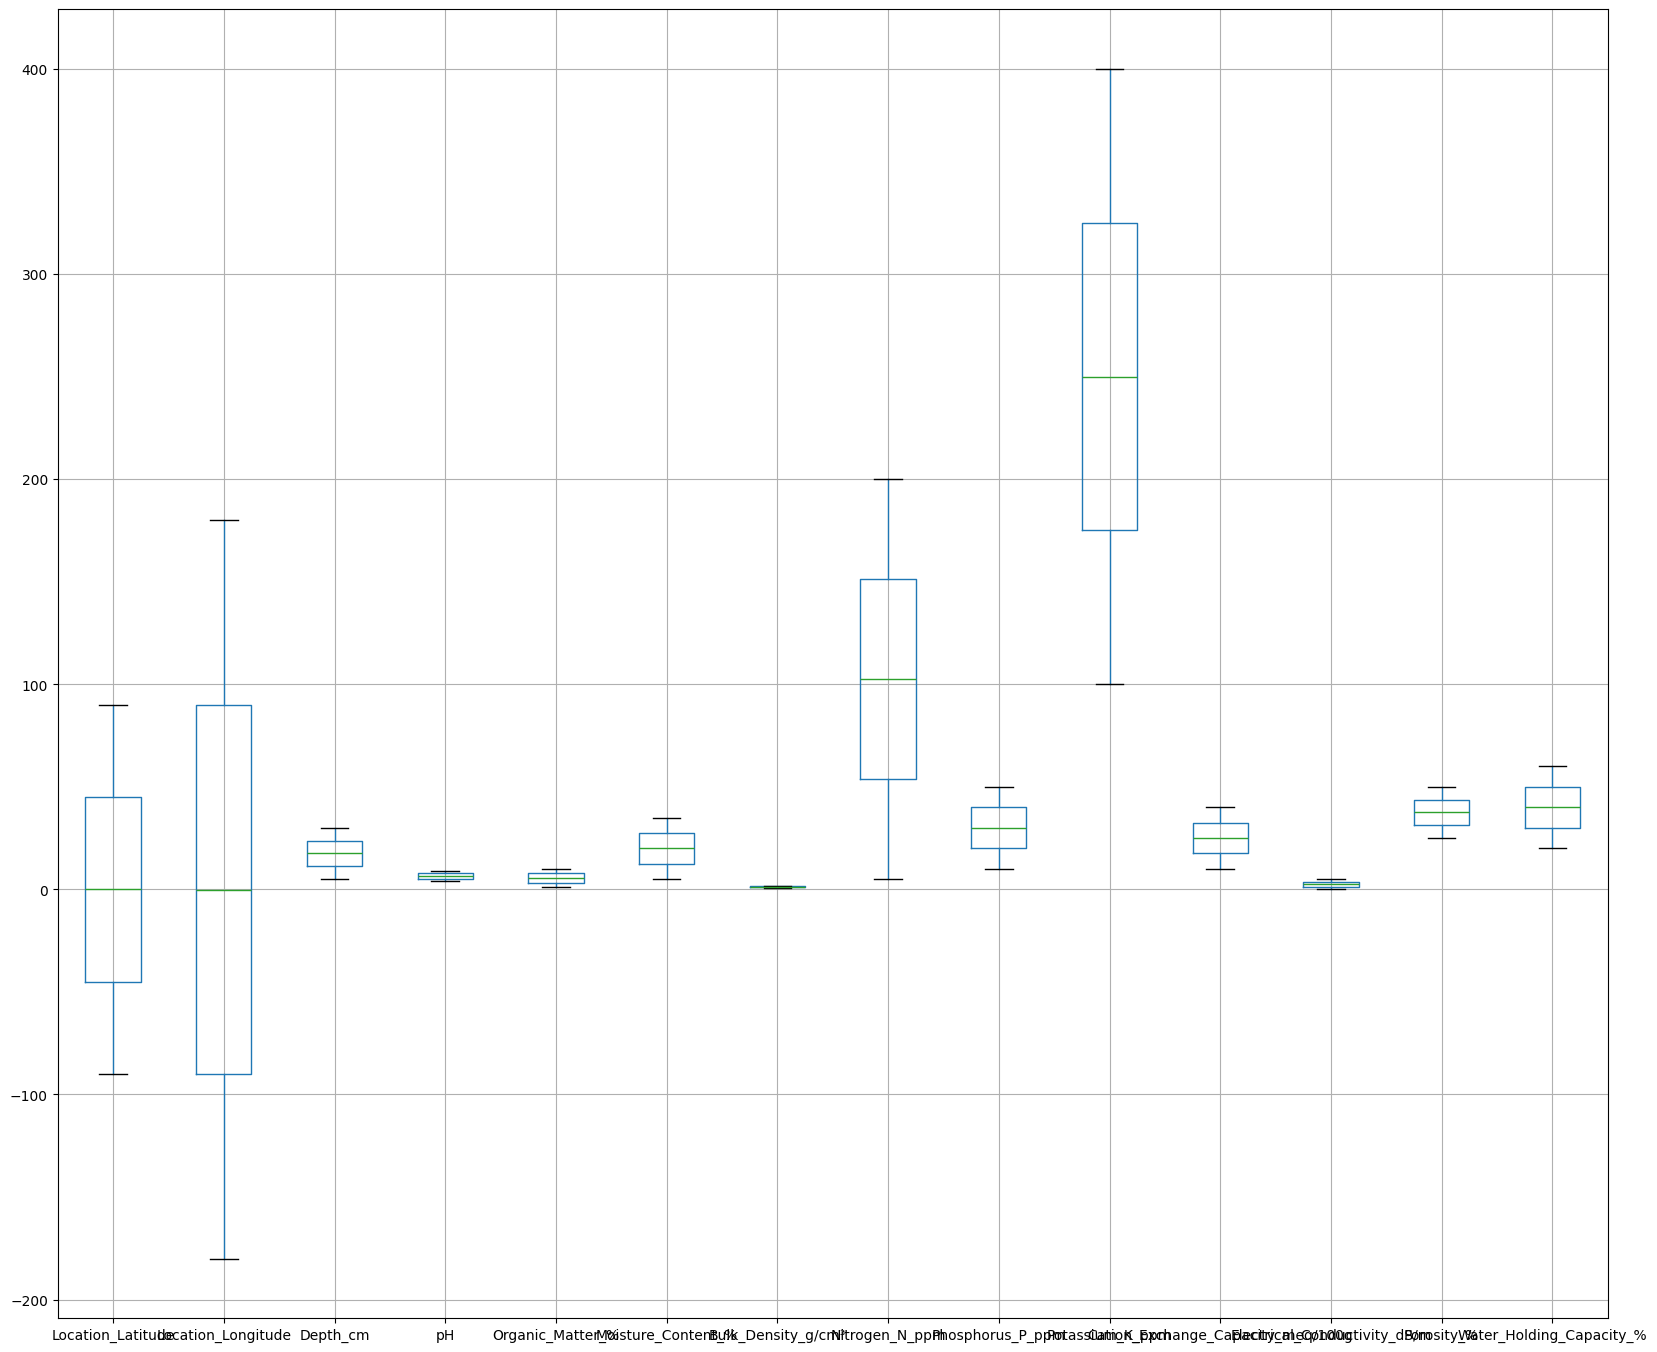

In [14]:
plt.figure(figsize=(20, 17))
number_columns.boxplot()

Okej, ovo gore je dosta nepregledno, hajde da odvojimo na vise slika

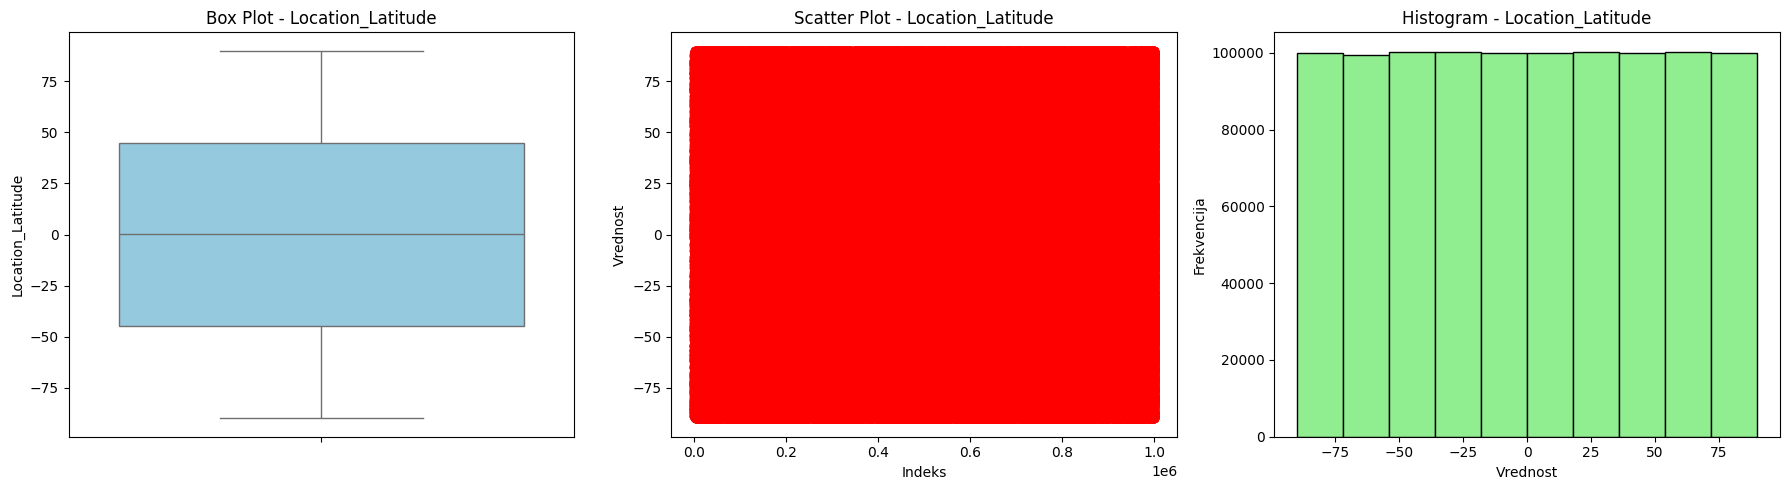

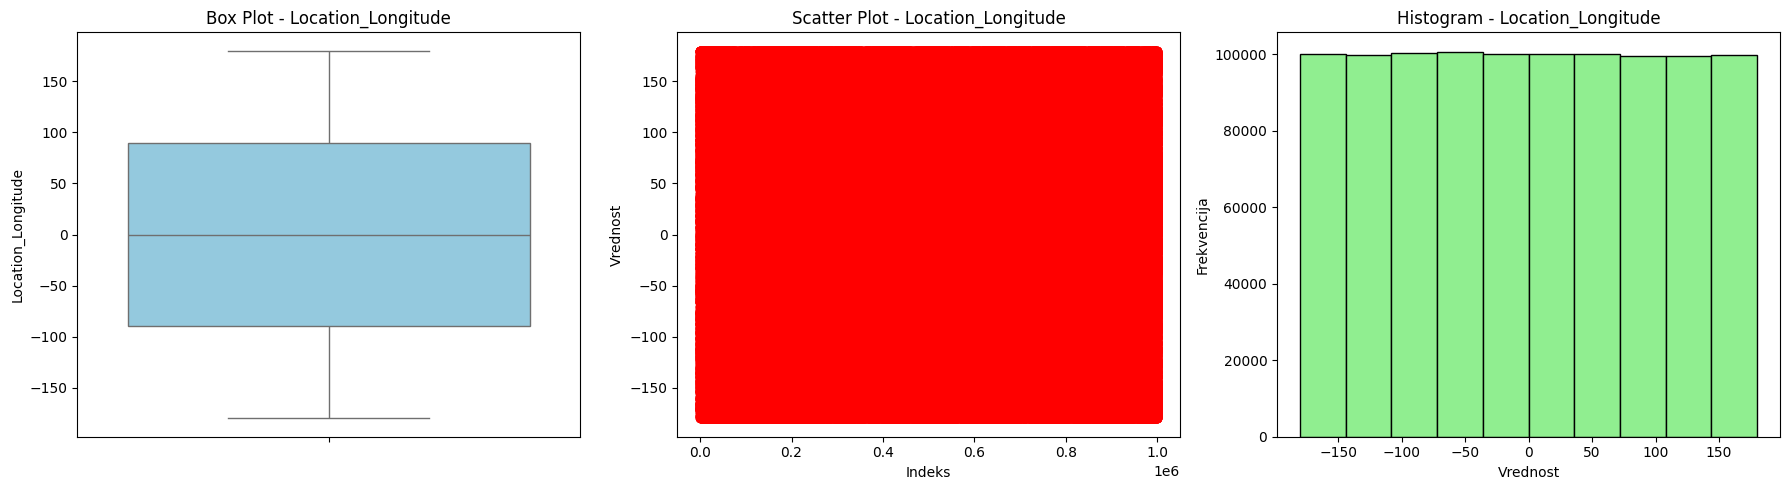

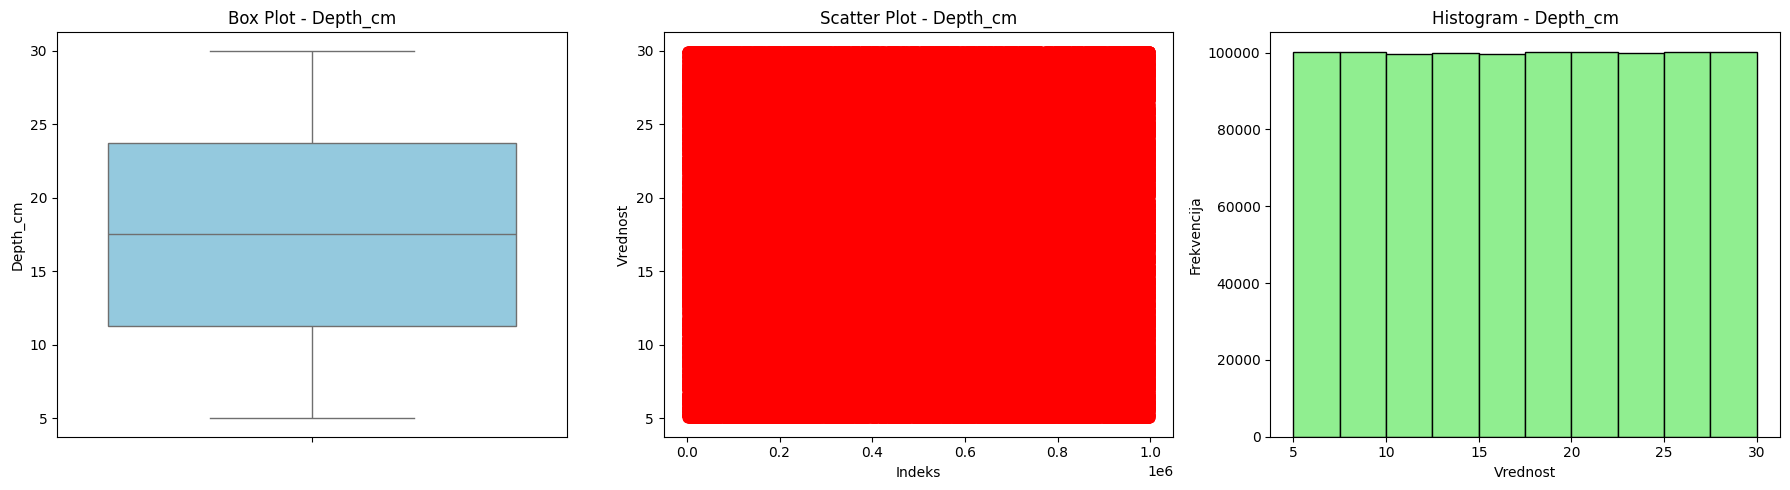

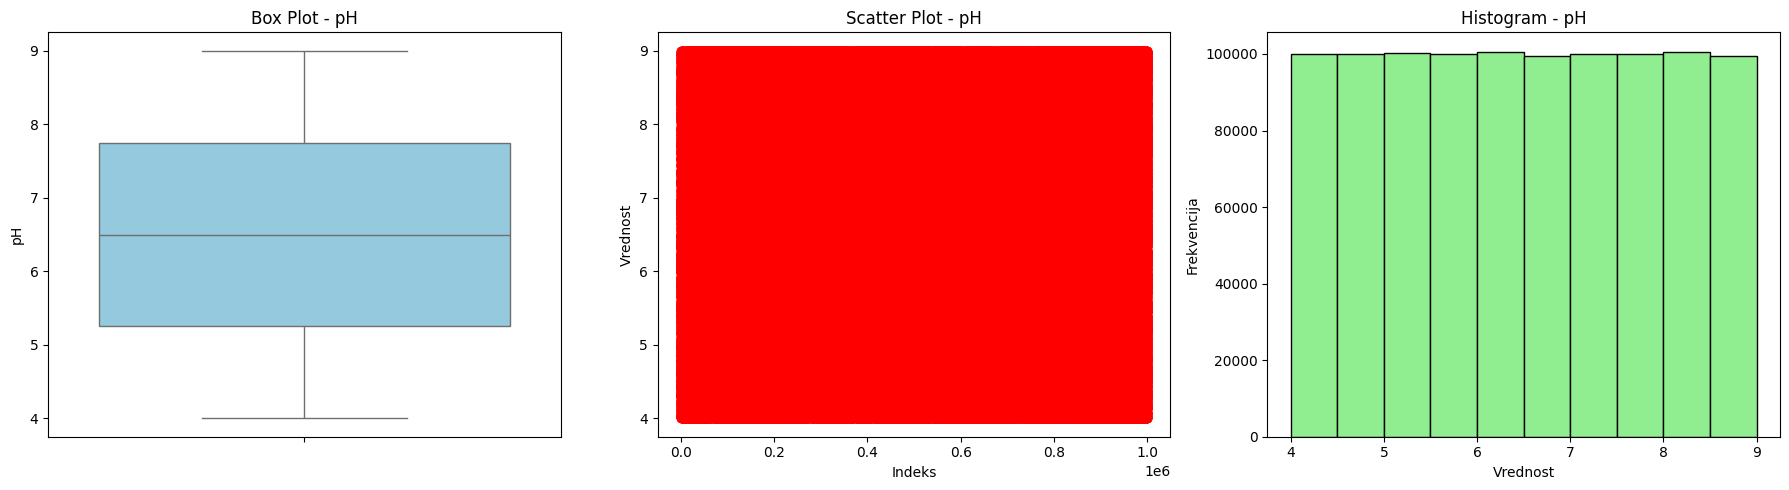

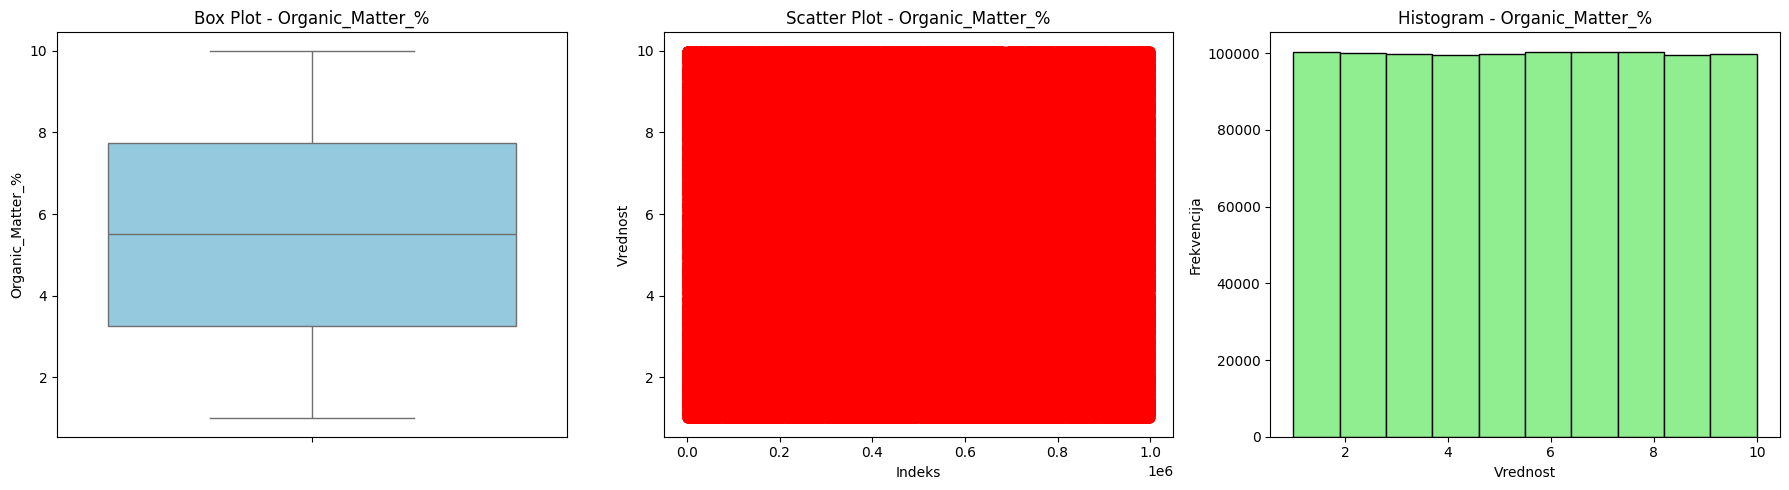

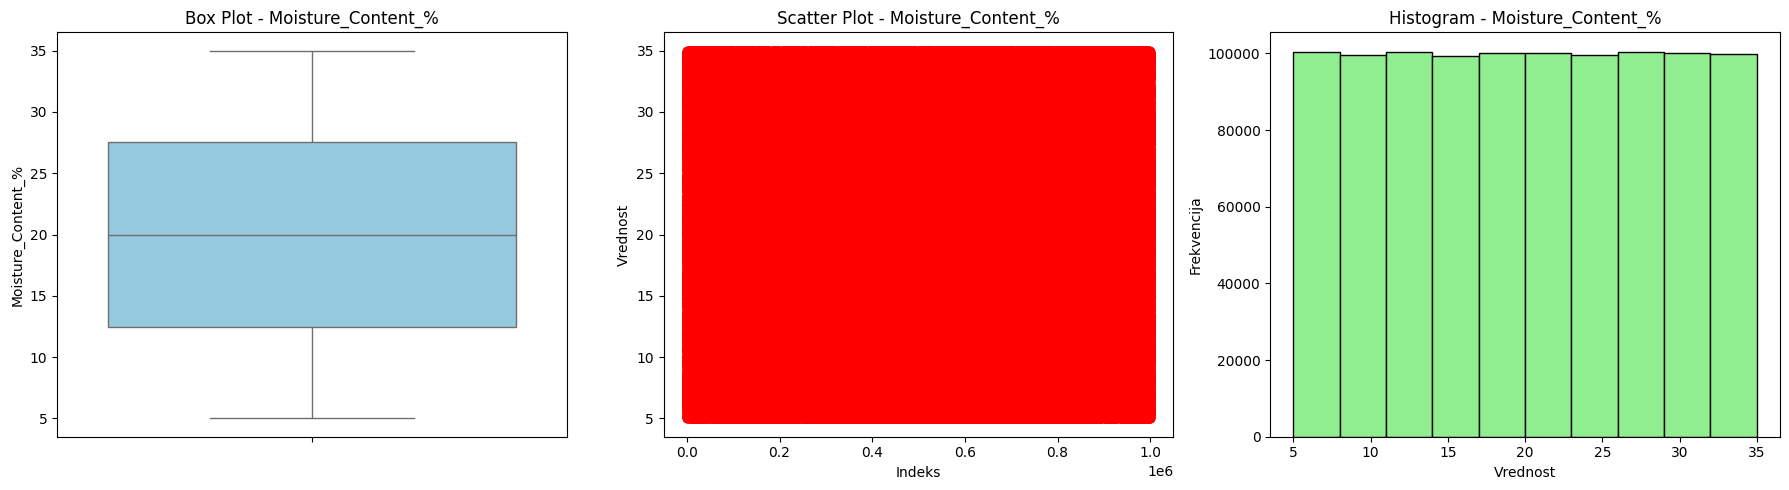

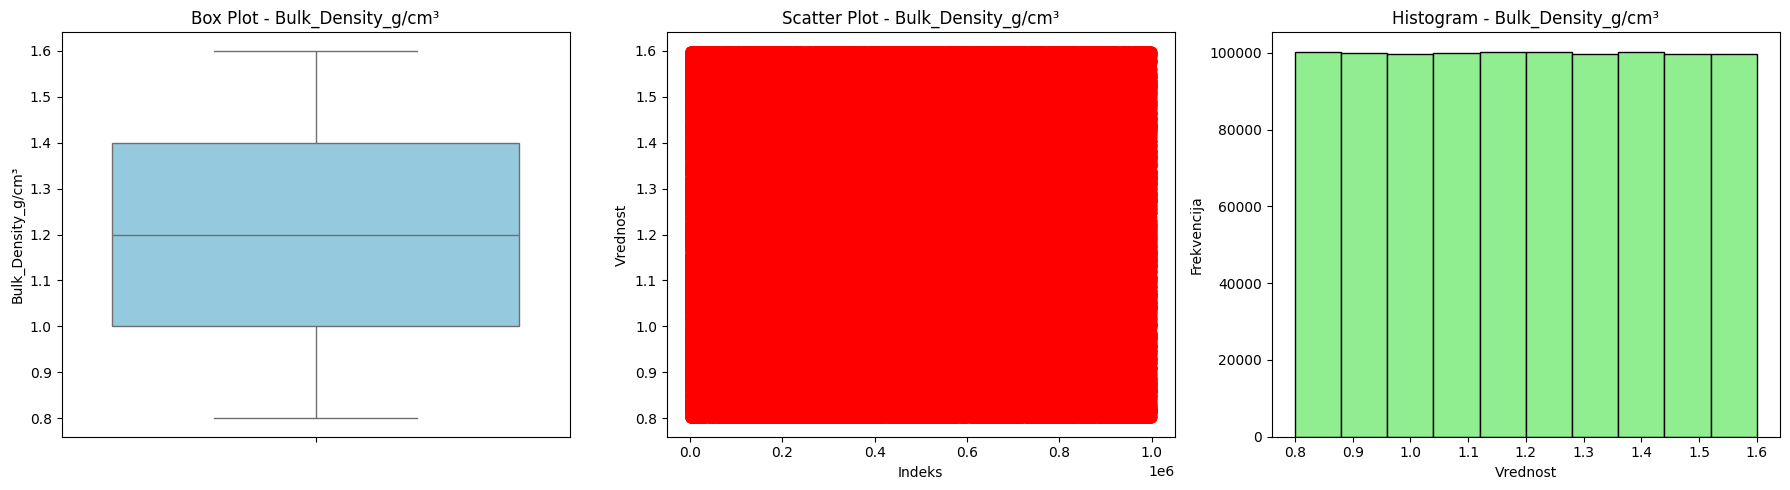

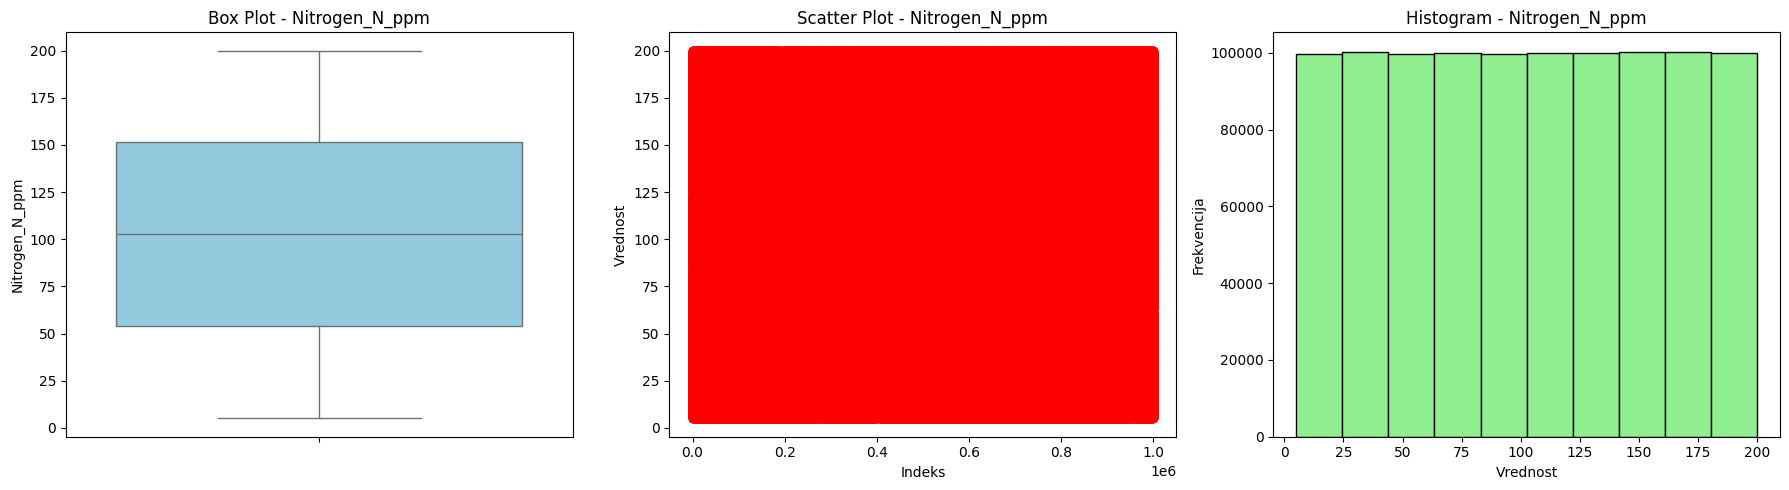

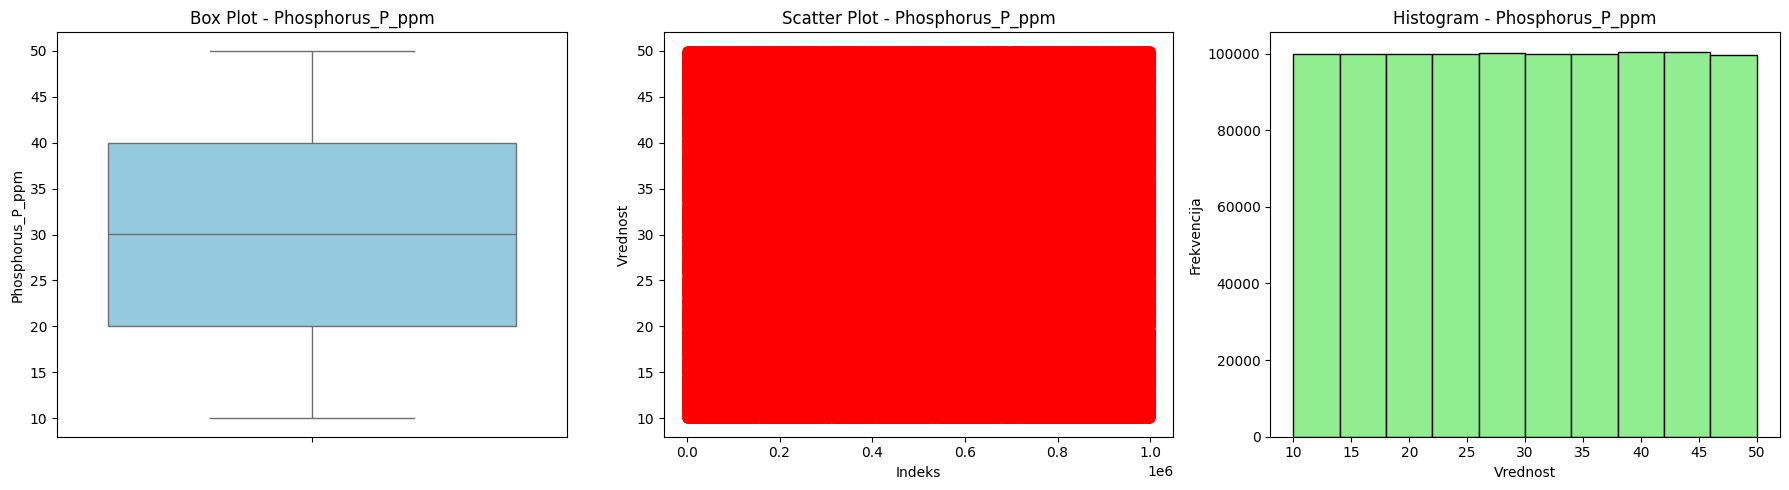

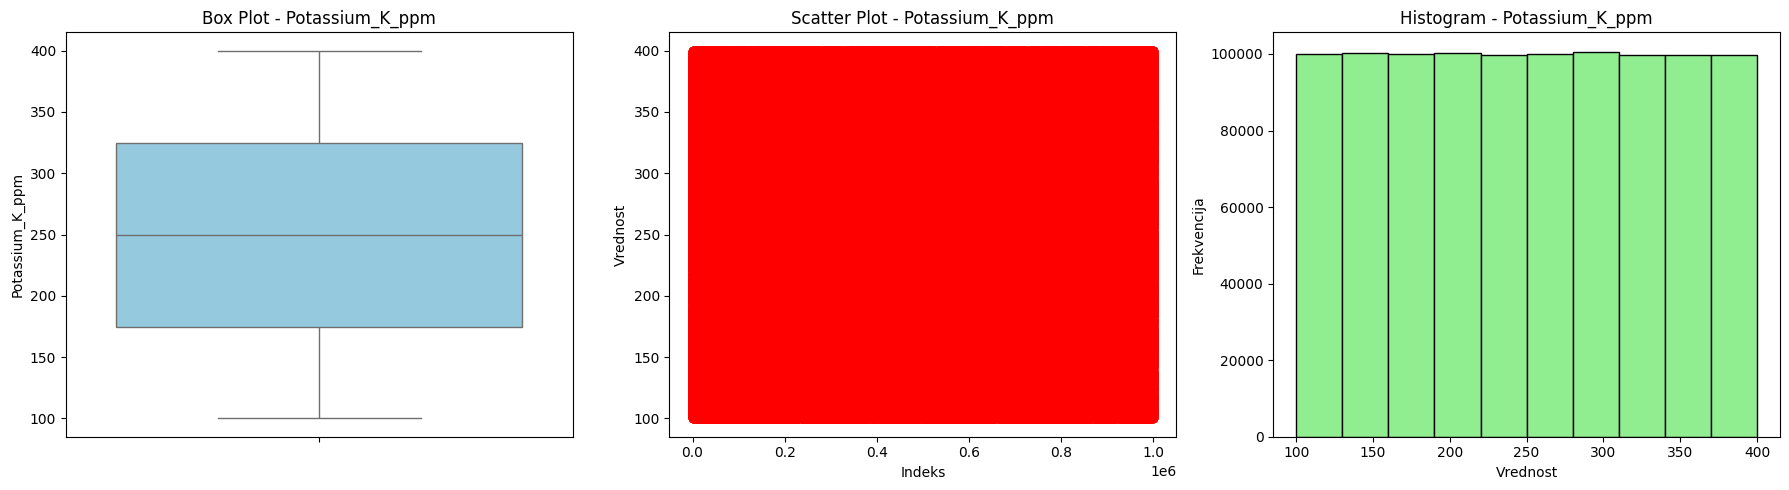

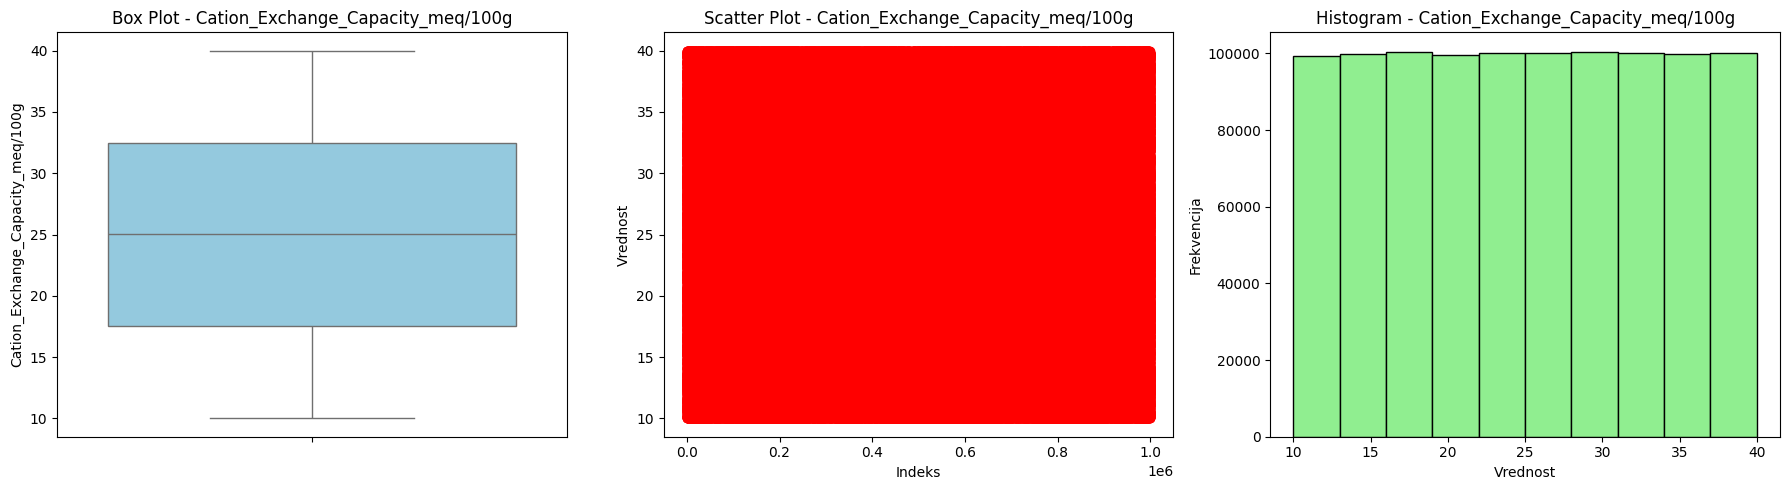

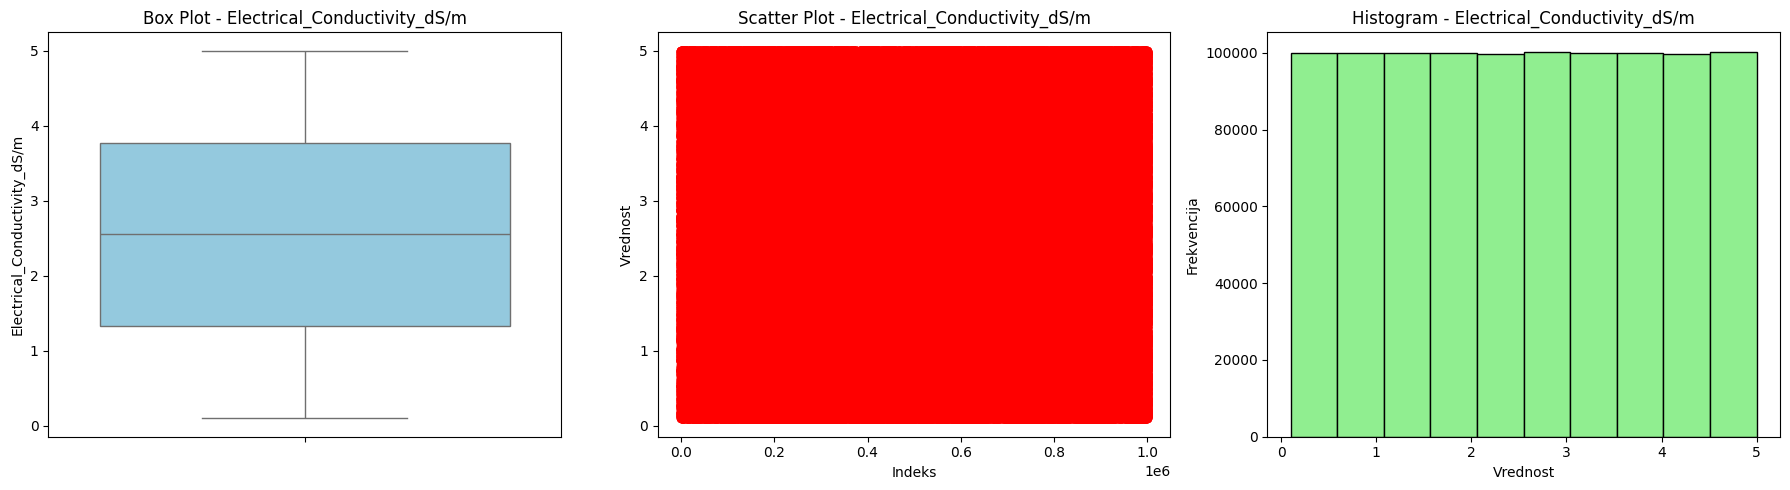

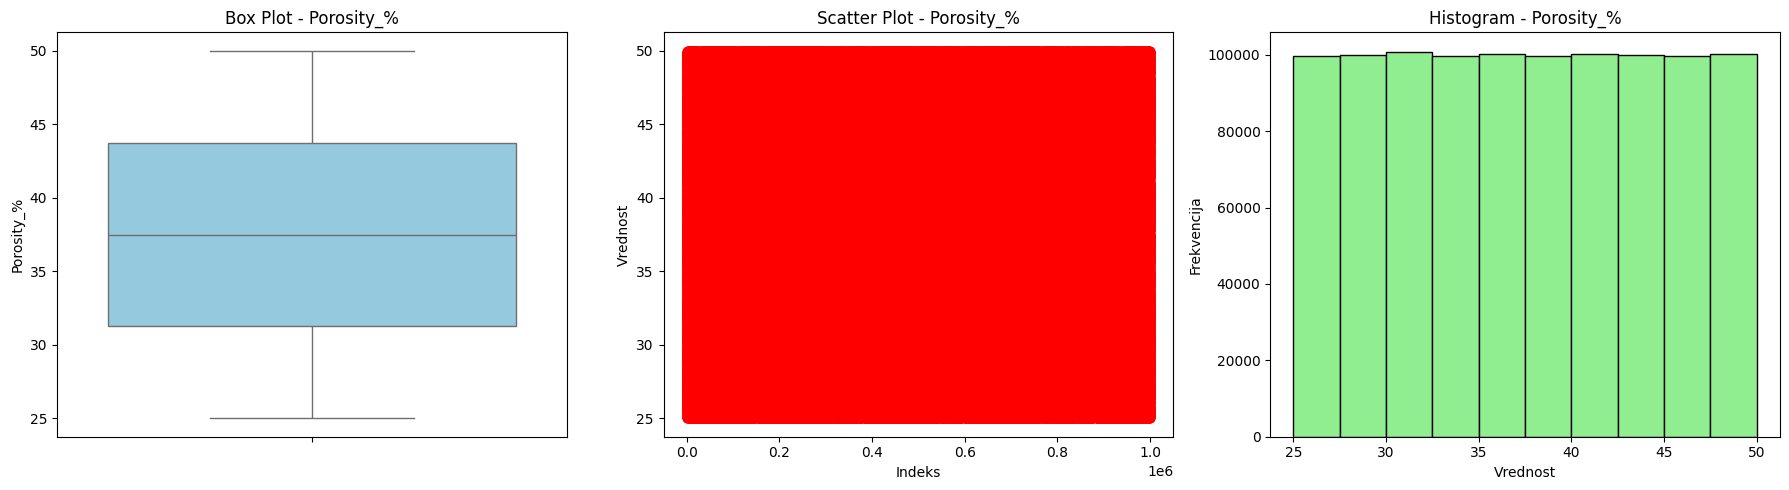

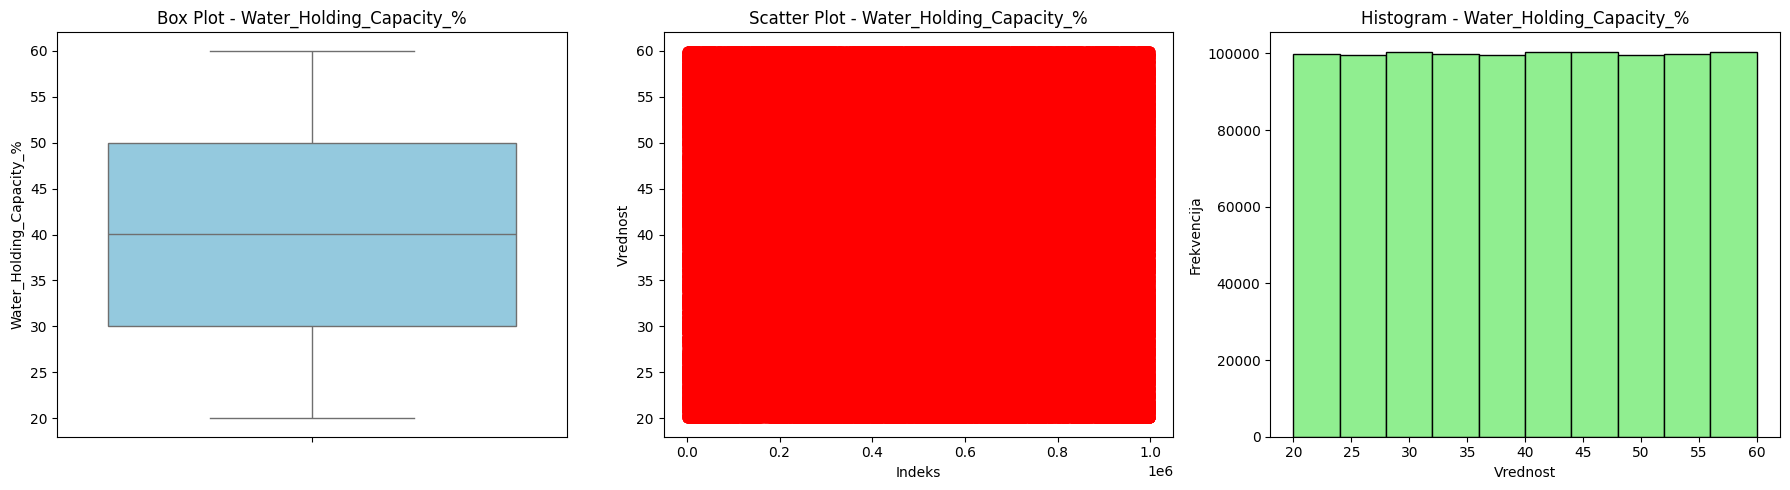

In [15]:
for column in number_columns.columns:
        plt.figure(figsize=(18, 5))
        
        # Box plot
        plt.subplot(1, 3, 1)
        sns.boxplot(y=df[column], color='skyblue')
        plt.title(f"Box Plot - {column}")
        
        # Scatter plot
        plt.subplot(1, 3, 2)
        plt.scatter(x=range(len(df)), y=df[column], color='red')
        plt.title(f"Scatter Plot - {column}")
        plt.xlabel("Indeks")
        plt.ylabel("Vrednost")
        
        # Histogram
        plt.subplot(1, 3, 3)
        plt.hist(df[column], bins=10, color='lightgreen', edgecolor='black')
        plt.title(f"Histogram - {column}")
        plt.xlabel("Vrednost")
        plt.ylabel("Frekvencija")
        
        plt.tight_layout()
        plt.show()

Posto outlinera nema...nemamo sta da uklonimo valjda

In [16]:
for column in number_columns.columns:
        print(f"\n--- Kolona: {column} ---")
        
        # IQR metoda
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        donja_granica = Q1 - 1.5 * IQR
        gornja_granica = Q3 + 1.5 * IQR
        outlieri_iqr = df[(df[column] < donja_granica) | (df[column] > gornja_granica)]
        print("Outlieri po IQR metodi:")
        print(outlieri_iqr)
        
        # Z-Score metoda
        mean = df[column].mean()
        std = df[column].std()
        z_scores = (df[column] - mean) / std
        outlieri_zscore = df[(z_scores > 3) | (z_scores < -3)]
        print("Outlieri po Z-Score metodi:")
        print(outlieri_zscore)


--- Kolona: Location_Latitude ---
Outlieri po IQR metodi:
Empty DataFrame
Columns: [Soil_ID, Location_Latitude, Location_Longitude, Depth_cm, Texture, pH, Organic_Matter_%, Moisture_Content_%, Bulk_Density_g/cm³, Nitrogen_N_ppm, Phosphorus_P_ppm, Potassium_K_ppm, Cation_Exchange_Capacity_meq/100g, Electrical_Conductivity_dS/m, Soil_Color, Porosity_%, Water_Holding_Capacity_%]
Index: []
Outlieri po Z-Score metodi:
Empty DataFrame
Columns: [Soil_ID, Location_Latitude, Location_Longitude, Depth_cm, Texture, pH, Organic_Matter_%, Moisture_Content_%, Bulk_Density_g/cm³, Nitrogen_N_ppm, Phosphorus_P_ppm, Potassium_K_ppm, Cation_Exchange_Capacity_meq/100g, Electrical_Conductivity_dS/m, Soil_Color, Porosity_%, Water_Holding_Capacity_%]
Index: []

--- Kolona: Location_Longitude ---
Outlieri po IQR metodi:
Empty DataFrame
Columns: [Soil_ID, Location_Latitude, Location_Longitude, Depth_cm, Texture, pH, Organic_Matter_%, Moisture_Content_%, Bulk_Density_g/cm³, Nitrogen_N_ppm, Phosphorus_P_ppm, Po

Kao sto vidimo i iye iqr i z-score metode ne postoje outliner-i


2. Transofrmacija podataka

Pretvaranje tekstualnih vrednosti u numeričke: One-Hot Encoding metoda


In [17]:
df_encoded = pd.get_dummies(df, columns=['Texture','Soil_Color'], prefix=['Texture','Soil_Color'])

In [18]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 22 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   Soil_ID                            1000000 non-null  int64  
 1   Location_Latitude                  1000000 non-null  float64
 2   Location_Longitude                 1000000 non-null  float64
 3   Depth_cm                           1000000 non-null  float64
 4   pH                                 1000000 non-null  float64
 5   Organic_Matter_%                   1000000 non-null  float64
 6   Moisture_Content_%                 1000000 non-null  float64
 7   Bulk_Density_g/cm³                 1000000 non-null  float64
 8   Nitrogen_N_ppm                     1000000 non-null  float64
 9   Phosphorus_P_ppm                   1000000 non-null  float64
 10  Potassium_K_ppm                    1000000 non-null  float64
 11  Cation_Exchange_Capacity_

In [19]:
df_encoded.iloc[:, 18:21].head(10)

,Soil_Color_black,Soil_Color_brown,Soil_Color_red
0,False,False,True
1,False,False,False
2,False,False,False
3,True,False,False
4,True,False,False
5,False,False,True
6,True,False,False
7,False,False,False
8,False,False,False
9,False,True,False


In [20]:
%pip install scikit-learn==1.7.1

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1) Encode your single Texture column
le = LabelEncoder()
y = le.fit_transform(df['Texture'])

# 2) Drop *all* target‐related columns from X
X = df_encoded.drop(
    ['Texture_clayey','Texture_loamy','Texture_sandy','Soil_ID'],
    axis=1
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)
print(f"Accuracy: {forest.score(X_test, y_test):.4f}")

Accuracy: 0.3327


In [30]:
from sklearn.model_selection import train_test_split

X_data = df_encoded.drop(['Texture_clayey', 'Texture_loamy', 'Texture_sandy'], axis=1)
y_data = df_encoded[['Texture_clayey', 'Texture_loamy', 'Texture_sandy']]
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size = 0.2, random_state = 1)
print(X_train_data.shape)
print(X_test_data.shape)
print(y_train_data.shape)
print(y_test_data.shape)

(800000, 19)
(200000, 19)
(800000, 3)
(200000, 3)


Treniranje modela:


Random Forest:

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 0, n_jobs = -1).fit(X_train_data, y_train_data)
print(forest.score(X_test_data, y_test_data))
pred=forest.predict(X_test_data)



0.00044


In [33]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

cv=KFold(n_splits=5, shuffle=True, random_state=12)

dtree_model=make_pipeline(StandardScaler(), RandomForestClassifier(random_state = 0, n_jobs = -1))
score=cross_val_score(dtree_model, X_test_data, y_test_data, cv=cv, scoring="accuracy")
average=np.mean(score)
print(f"Average Cross Validation Accuracy:  {average*100:.2f}%")

Average Cross Validation Accuracy:  0.06%
